<a href="https://colab.research.google.com/github/yk4r2/GAN/blob/master/toy_example_standard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 7)
import tensorflow as tf
print(tf.__version__)
RANGE = 5

TensorFlow 1.x selected.
1.15.2


In [0]:
# p_d(x)
class DataDistribution(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def sample(self, N):
        samples = np.random.normal(self.mu, self.sigma, N)
        samples.sort()
        return samples


# p_z(z)
class NoiseDistribution(object):
    def __init__(self, range):
        self.range = range

    # equally spaced samples + noise
    def sample(self, N):
        offset = np.random.random(N) * (float(self.range) / N)
        samples = np.linspace(-self.range, self.range, N) + offset
        return samples


# G(z)
def generator(x, n_hidden=32):

    # initializers
    w_init = tf.truncated_normal_initializer(stddev=2)
    b_init = tf.constant_initializer(0.)

    # 1st hidden layer
    w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
    b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)

    # output layer
    w1 = tf.get_variable('w1', [h0.get_shape()[1], 1], initializer=w_init)
    b1 = tf.get_variable('b1', [1], initializer=b_init)
    o = tf.matmul(h0, w1) + b1

    return o


# D(x)
def discriminator(x, n_hidden=32):

    # initializers
    w_init = tf.contrib.layers.variance_scaling_initializer()
    b_init = tf.constant_initializer(0.)

    # 1st hidden layer
    w0 = tf.get_variable('w0', [x.get_shape()[1], n_hidden], initializer=w_init)
    b0 = tf.get_variable('b0', [n_hidden], initializer=b_init)
    h0 = tf.nn.relu(tf.matmul(x, w0) + b0)

    # output layer
    w1 = tf.get_variable('w1', [h0.get_shape()[1], 1], initializer=w_init)
    b1 = tf.get_variable('b1', [1], initializer=b_init)
    o = tf.sigmoid(tf.matmul(h0, w1) + b1)

    return o

In [0]:
# re-used for optimizing all networks
def optimizer(loss, var_list, num_decay_steps=400, initial_learning_rate=1e-4):
    decay = 0.95
    batch = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        initial_learning_rate,
        batch,
        num_decay_steps,
        decay,
        staircase=True
    )
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(
        loss,
        global_step=batch,
        var_list=var_list
    )
    return optimizer

In [0]:
class ResultPlot(object):
    def __init__(self, num_points, num_bins, mu, sigma):
        self.num_points = num_points    # number of data points to be evaluated
        self.num_bins = num_bins        # number of bins to get histogram

        self.mu = mu                    # mu of p_data
        self.sigma = sigma              # sigma of p_data

        self.xs = np.linspace(-RANGE, RANGE, num_points)    # positions of data
        self.bins = np.linspace(-RANGE, RANGE, num_bins)    # positions of bins

    def show_results(self, db_init, db_trained, pd, pg, save_img=True):
        db_x = np.linspace(-RANGE, RANGE, len(db_trained))
        p_x = np.linspace(-RANGE, RANGE, len(pd))
        f, ax = plt.subplots(1)
        ax.plot(db_x, db_init, 'g--', linewidth=2, label='db_init')
        ax.plot(db_x, db_trained, 'g-', linewidth=2, label='db_trained')
        ax.set_ylim(0, max(1, np.max(pd) * 1.1))
        ax.set_xlim(-4, 4)
        plt.plot(p_x, pd, 'b-', linewidth=2, label='real data')
        plt.plot(p_x, pg, 'r-', linewidth=2, label='generated data')
        plt.title('1D Generative Adversarial Network: ' + '(mu : %3g,' % self.mu + ' sigma : %3g)' % self.sigma)
        plt.xlabel('Data values')
        plt.ylabel('f(x)')
        plt.legend()
        plt.grid(True)

        if save_img:
            plt.savefig('GAN_1d_gaussian' + '_mu_%g' % self.mu + '_sigma_%g' % self.sigma + '.png')

        plt.show()



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

[0/8000]: loss_d : 0.544, loss_g : 1.546
[1000/8000]: loss_d : 0.211, loss_g : 3.460
[2000/8000]: loss_d : 1.116, loss_g : 2.232
[3000/8000]: loss_d : 1.448, loss_g : 2.219
[4000/8000]: loss_d : 1.086, loss_g : 2.398
[5000/8000]: loss_d : 1.006, loss_g : 2.586
[6000/8000]: loss_d : 1.009, loss_g : 2.565
[7000/8000]: loss_d : 1.009, loss_g : 2.525


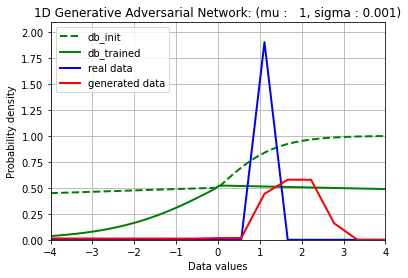

In [5]:
def main():
    """ parameters """
    # p_data
    mu = 1
    sigma = 1e-3

    # training
    B = 32                 # batch-size
    LR = 1e-4              # learning rate (generator uses half of this)
    TRAIN_ITERS = 8000      # number of iterations

    # network
    n_hidden = 32           # number of hidden layers

    """ build graph """


    # networks : generator
    with tf.variable_scope('Gen'):
        z = tf.placeholder(tf.float32, shape=(None, 1))
        G_z = generator(z, n_hidden)

    # networks : discriminator
    with tf.variable_scope('Disc') as scope:
        x = tf.placeholder(tf.float32, shape=(None, 1))
        D_real = discriminator(x, n_hidden)
        scope.reuse_variables()
        D_fake = discriminator(G_z, n_hidden)

    # loss for each network
    eps = 1e-2  # to prevent log(0) case

    loss_g = tf.reduce_mean(-tf.log(D_fake + eps))
    loss_d = tf.reduce_mean(-tf.log(D_real + eps) - tf.log(1 - D_fake + eps))

    # trainable variables for each network
    d_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Disc')
    g_params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Gen')

    # optimizer for each network
    opt_d = optimizer(loss_d, d_params, 400, LR)
    opt_g = optimizer(loss_g, g_params, 400, LR / 2)

    """ training """

    # open session and initialize all variables
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()

    # sources
    p_data = DataDistribution(mu, sigma)
    p_z = NoiseDistribution(RANGE)

    # class for result-plot
    plot = ResultPlot(10000, 20, mu, sigma)

    # plot : initial decision boundary
    db_init = np.zeros((plot.num_points, 1))
    for i in range(plot.num_points // B):
        db_init[B * i:B * (i + 1)] = sess.run(D_real, {x: np.reshape(plot.xs[B * i:B * (i + 1)], (B, 1))})

    # training-loop
    for step in range(TRAIN_ITERS):

        np.random.seed(np.random.randint(0, TRAIN_ITERS))

        # update discriminator
        x_ = p_data.sample(B)
        z_ = p_z.sample(B)

        loss_d_, _ = sess.run([loss_d, opt_d], {x: np.reshape(x_, (B, 1)), z: np.reshape(z_, (B, 1))})

        # update generator
        z_ = p_z.sample(B)
        loss_g_, _ = sess.run([loss_g, opt_g], {z: np.reshape(z_, (B, 1))})

        if step % 1000 == 0:
            print('[%d/%d]: loss_d : %.3f, loss_g : %.3f' % (step, TRAIN_ITERS, loss_d_, loss_g_))

    """ show results """

    # plot : trained decision boundary
    db_trained = np.zeros((plot.num_points, 1))
    for i in range(plot.num_points // B):
        db_trained[B * i:B * (i + 1)] = sess.run(D_real, {x: np.reshape(plot.xs[B * i:B * (i + 1)], (B, 1))})

    # plot : pdf of data distribution
    d = p_data.sample(plot.num_points)
    pd, _ = np.histogram(d, bins=plot.bins, density=True)

    # plot : pdf of generated samples
    zs = np.linspace(-RANGE, RANGE, plot.num_points)
    g = np.zeros((plot.num_points, 1))
    for i in range(plot.num_points // B):
        g[B * i:B * (i + 1)] = sess.run(G_z, {z: np.reshape(zs[B * i:B * (i + 1)], (B, 1))})
    pg, _ = np.histogram(g, bins=plot.bins, density=True)

    # plot results
    plot.show_results(db_init, db_trained, pd, pg, save_img=True)

    sess.close()


if __name__ == '__main__':
    main()
